# Fine Tune Test 
Making a test for fine tuning for planning projections

In [24]:
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from huggingface_hub import login, snapshot_download, hf_hub_download
from datasets import load_dataset
from trl import SFTTrainer
import torch
import math
from tqdm import tqdm
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
import os
import torch.nn as nn
import pynvml
import matplotlib.pyplot as plt
from accelerate import init_empty_weights, infer_auto_device_map
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# check VRAM
# if not using Cheery, you will need to change this
def check_vram():
    # Initialize NVIDIA management library
    pynvml.nvmlInit()

    # Get a handle for each GPU device
    handle_list = [pynvml.nvmlDeviceGetHandleByIndex(i) for i in range(pynvml.nvmlDeviceGetCount())]

    info_used = []
    points = [0,1,2,3,4,5,6,7]
    max_vram = 24

    # Iterate over all GPU devices and print VRAM usage
    for handle in handle_list:
        info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        info_used.append( (info.used//1024**2)/1000)

    print (info_used)

    plt.figure(figsize=(5, 2))
    plt.ylim(0,max_vram)
    plt.bar(points, info_used)
    plt.plot()
    pynvml.nvmlShutdown()

In [ ]:
"""
DO NOT RUN THIS CODE BLOCK IF 'llama-2-7b' IS IN YOUR DIRECTORY
"""

# getting the authorisation from huggingface to use the model (in this case llama 2 7b )
access_key = open('hf_ak.txt','r').read()
login(token = access_key)

# Download model files. If it's in the project directory, there's no need to run this again
# use df -H in the terminal to check and see if there's enough space to download the model
# this process will take a long time
# will save the model in the directory specified
model_path = snapshot_download("meta-llama/Llama-2-7b", local_dir="./llama-2-7b")

- do not run any of this is if llama-2-7b-hf is filled
- You'll need to convert them to the huggingface Transformers format using the conversion script `convert_llama_weights_to_hf.py`. 
- Obviously, hf stands for huggingface. Maybe with the hf version, the conversion wouldn't be needed
- to run this, run the following

```
python convert_llama_weights_to_hf.py \
    --input_dir /llama-2-7b --model_size 7B --output_dir /llama-2-7b-hf

```

[1.079, 5.791, 0.418, 4.677, 0.418, 0.418, 0.418, 0.418]


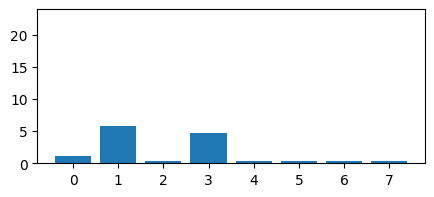

In [4]:
check_vram()

In [5]:
# each GPU util
!nvidia-smi --query-gpu=utilization.gpu --format=csv

utilization.gpu [%]
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %


In [6]:
# pointing to the hf version of the model
model_path = "llama-2-7b-hf"

# device_map auto -> distribute data and compute across the GPU's automatically
model = AutoModelForCausalLM.from_pretrained(
    model_path, 
    device_map = "sequential",
    trust_remote_code = True,
)

# using the tokenizer that this model has
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b")

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly rea

[23.404, 9.588, 0.625, 4.884, 0.625, 0.625, 0.625, 0.625]


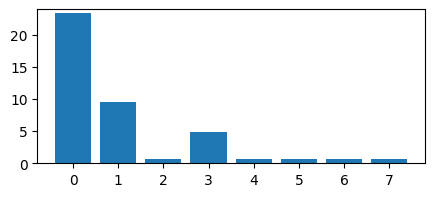

In [7]:
# making sure model gets loaded correctly
check_vram()

In [ ]:
# run this to clear VRAM
del model
del tokenizer

In [10]:
# run this to clear VRAM
torch.cuda.empty_cache()

In [8]:
# freezing the og weights
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [9]:
# init lora adapters
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [10]:
from peft import LoraConfig, get_peft_model 

config = LoraConfig(
    r=16, #attention heads
    lora_alpha=32, #alpha scaling
    # target_modules=["q_proj", "v_proj"], #if you know the 
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM" # set this for CLM or Seq2Seq
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8388608 || all params: 6746804224 || trainable%: 0.12433454005023165


In [18]:
# getting the data
# getting the dataset from hugging face library
# using this so we don't have to reformat which we'll get into later
ds = load_dataset("google/frames-benchmark")

Generating test split: 100%|██████████| 824/824 [00:01<00:00, 452.25 examples/s]


In [23]:
data = ds["test"]

# prompts
data_x = data

# answers to the prompts
data_y = data

train_data, temp_data, train_y, temp_y = train_test_split(data_x, data_y, test_size=0.3, random_state=30)
val_data, test_data, val_y, test_y = train_test_split(temp_data, temp_y, test_size=0.5, random_state=30)

In [14]:
trainer = transformers.Trainer(
    model=model, 
    train_dataset=ds['train'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4, 
        gradient_accumulation_steps=4,
        warmup_steps=10,
        max_steps=20,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

KeyError: 'train'